In [ ]:
from google.colab import drive

drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/Colab Notebooks/cubricks'

In [ ]:
!pip -q install imbalanced-learn --upgrade

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

seed = 42

In [ ]:
def plot_data_distribution(df1, df2=None, title=None):
    if df2 is not None:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 2))
        sns.countplot(np.squeeze(df1), ax=ax[0])
        sns.countplot(np.squeeze(df2), ax=ax[1])
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 2))
        sns.countplot(np.squeeze(df1), ax=ax)

def plot_confuncion_matrix(y_test, predict, title='Confusion Matrix'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    sns.heatmap(confusion_matrix(y_test, predict), fmt='d', square=True, annot=True, cmap='Blues', ax=ax).set_title(title)

def plot_feature_importance(features, importances, plot=True):
    indices = np.argsort(importances)[::-1]
    print(f'Feature ranking:')

    for f in range(x_train.shape[1]):
        print(f'{importances[indices[f]]}\t{features[indices[f]]}')

    if plot:
        plt.figure(figsize=(10, 8))
        plt.barh(range(x_train.shape[1]), importances[indices])
        plt.yticks(range(x_train.shape[1]), features[indices])
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()
        plt.show()

def setup_buckets(df, bins, columns, ontime=True, sufix='Bucket'): 
    bins = ([-np.inf] if ontime else []) + bins + [np.inf]
    labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins[:-1]))]
    labels[0] = 'on-time' if ontime else labels[0]
    labels[-1] = labels[-1].replace('-inf', '+')

    for col in columns:
        bucket_col = col + sufix
        df[bucket_col] = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)
        df[[bucket_col + 'CT']] = df[[bucket_col]].apply(lambda x: pd.Categorical(x, ordered=True).codes)
    return (df, labels)

def split_data_month_window(df, col, date, month_window):
    date_0 = pd.to_datetime(date)
    date_1 = date_0 - pd.DateOffset(months=month_window)
    date_2 = date_0 + pd.DateOffset(months=1)

    train = df[(df[col] >= date_1) & (df[col] < date_0)]
    test = df[(df[col] >= date_0) & (df[col] < date_2)]

    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    return train, test

def resample(df, x_column, y_column, func):
    dtypes = df[x_column].dtypes.to_dict()
    dtypes.update(df[y_column].dtypes.to_dict())

    x, y = df[x_column].values, df[y_column].values
    x, y = func.fit_resample(x, y)
    xy = np.concatenate((x, np.expand_dims(y, axis=1)), axis=1)
    
    data = pd.DataFrame(xy, columns=np.concatenate((x_column, y_column)))
    data = data.astype(dtypes)
    return data

def features_selection(train, test, x_column, y_column, threshold=1, random_state=None):
    from itertools import combinations
    import multiprocessing
    import functools

    total = len(x_column)
    predicts = []

    for i in range(total, threshold-1, -1):
        print(f'>>>\r{round((1-((i-threshold)/total)) * 100, 1)}% complete', end='')
        cb = sum([list(map(list, combinations(x_column, y))) for y in range(i, i + 1)], [])

        with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
            pd = pool.map(functools.partial(_selection, train, test, x_column, y_column, random_state), cb)
            pd = np.array(pd, dtype=object)
            pool.close()
            pool.join()

        if i == total:
            x_column = x_column[np.argsort(pd[:,2][0])[::-1]]

        index_max = np.argmax(pd[:,0])
        index_del = [i for i, item in enumerate(x_column) if item not in pd[index_max][1]]

        predicts.append(pd[index_max])
        x_column = np.delete(x_column, index_del)

    predicts = np.array(predicts, dtype=object)
    predicts = predicts[predicts[:,0].argsort()][::-1]
    index_max = np.argmax(predicts[:,0])
    return (predicts, index_max)

def _selection(*args):
    train, test, x_column, y_column, random_state, features = args

    x_train, y_train = train[features].values, train[y_column].values
    x_test, y_test = test[features].values, test[y_column].values

    clf = RandomForestClassifier(n_estimators=25, criterion='entropy', random_state=random_state)
    clf.fit(x_train, np.squeeze(y_train))

    cr = classification_report(y_test, clf.predict(x_test), output_dict=True, zero_division=True)
    return [cr['macro avg']['f1-score'], features, clf.feature_importances_]

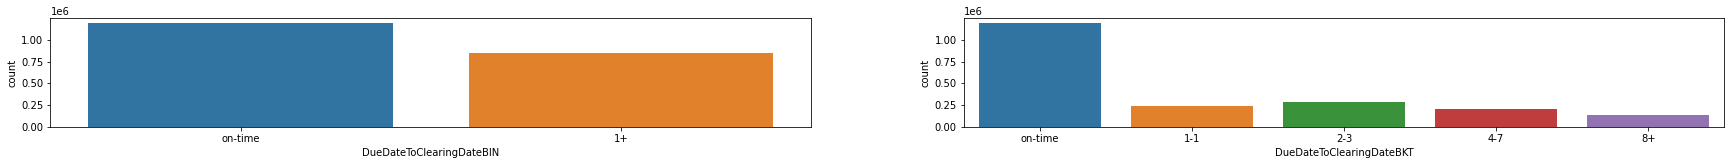

In [ ]:
### READ ###
df = pd.read_csv('InvoicedDocuments_v5.csv', sep=';', na_values=['N/I'], parse_dates=['DocumentDate', 'DueDate', 'ClearingDate'])
df.sort_values(by=['DocumentDate'], ascending=True, ignore_index=True, inplace=True)


### FILTERS ###
df.dropna(subset=['ClearingDate', 'PaymentTerms'], inplace=True)

df = df[(df['DueDate'] > df['DocumentDate']) & (df['ClearingDate'] > df['DocumentDate'])]
df = df[df['DocumentAmount'] > 1000]
df.reset_index(drop=True, inplace=True)


### PREPROCESSING ###
df.fillna(-1, inplace=True)
df['CustomerRegion'] = df['CustomerRegion'].apply(lambda x: 'N/I' if str(x).replace('-', '').isnumeric() else x)

integer_cols = ['InvoicedDocuments', 'PaidDocuments', 'PaidPastDocuments', 'OpenDocuments', 'PastDueDocuments']
df[integer_cols] = df[integer_cols].apply(pd.to_numeric, downcast='integer')

category_cols = ['CompanyKey', 'CustomerKey', 'CorporateDivision', 'CustomerRegion', 'PaymentTerms']
df[category_cols] = df[category_cols].apply(lambda x: pd.Categorical(x, ordered=True).codes)


### FEATURE GENERATION ###
amount_cols = ['InvoicedAmount', 'PaidAmount', 'PaidPastAmount', 'OpenAmount', 'PastDueAmount']
count_cols = ['InvoicedDocuments', 'PaidDocuments', 'PaidPastDocuments', 'OpenDocuments', 'PastDueDocuments']

for amount, count in zip(amount_cols, count_cols):
    ratio_col = 'Ratio' + amount + count
    df[ratio_col] = df[amount] / df[count]
    df[ratio_col].fillna(0, inplace=True)

for col in ['DocumentDate', 'DueDate']:
    df[col + 'DayOfYear'] = pd.DatetimeIndex(df[col]).dayofyear
    df[col + 'WeekDay'] = pd.DatetimeIndex(df[col]).weekday
    df[col + 'Day'] = pd.DatetimeIndex(df[col]).day
    df[col + 'MonthEnd'] = df[col] + pd.offsets.MonthEnd(1)

df['DueDateToClearingDate'] = (df['ClearingDate'] - df['DueDate']).astype('timedelta64[D]').astype(int)
df['DueDateToMonthEnd'] = (df['DueDateMonthEnd'] - df['DueDate']).astype('timedelta64[D]').astype(int)
df['DocumentDateToDueDate'] = (df['DueDate'] - df['DocumentDate']).astype('timedelta64[D]').astype(int)
df['DocumentDateToMonthEnd'] = (df['DocumentDateMonthEnd'] - df['DocumentDate']).astype('timedelta64[D]').astype(int)

df, labels_bin = setup_buckets(df, bins=[1], columns=['DueDateToClearingDate'], sufix='BIN')
df, labels_bucket = setup_buckets(df, bins=[1, 2, 4, 8], columns=['DueDateToClearingDate'], sufix='BKT')

plot_data_distribution(df['DueDateToClearingDateBIN'], df['DueDateToClearingDateBKT'])

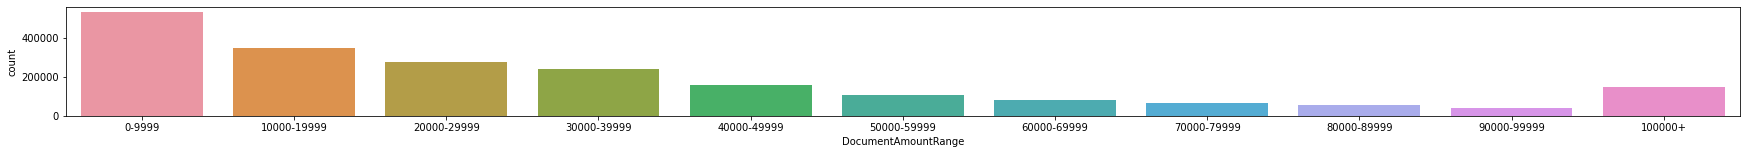

In [ ]:
df, _ = setup_buckets(df, bins=list(range(0, 110000, 10000)), columns=['DocumentAmount'], ontime=False, sufix='Range')

plot_data_distribution(df['DocumentAmountRange'])
# df.head()

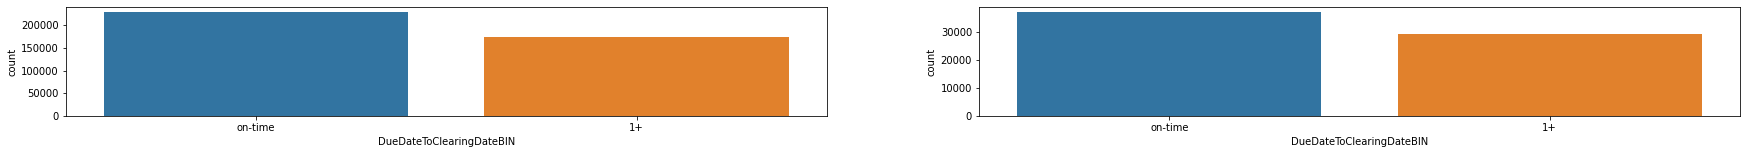

In [ ]:
y_column_bin = np.array(['DueDateToClearingDateBINCT'])
x_column_bin = np.array([
                        'AvgPastDueDays', 'CompanyKey', 'DueDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'DocumentDateToDueDate', 'DocumentDateWeekDay', 'RatioPaidAmountPaidDocuments', 'OpenAmount', 'CustomerKey', 'RatioOpenAmountOpenDocuments', 'DocumentDateDayOfYear', 'DueDateDay', 'DocumentDateToMonthEnd', 'DocumentDateDay', 'CustomerRegion',
                        # 'AvgPastDueDays', 'CompanyKey', 'DueDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'DocumentDateToDueDate', 'DocumentDateWeekDay', 'RatioPaidAmountPaidDocuments', 'OpenAmount', 'CustomerKey', 'DocumentDateDayOfYear', 'DueDateDay', 'DocumentDateToMonthEnd', 'DocumentDateDay',
                        # 'AvgPastDueDays', 'CompanyKey', 'DueDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'DocumentDateToDueDate', 'DocumentDateWeekDay', 'RatioPaidAmountPaidDocuments', 'OpenAmount', 'CustomerKey', 'DocumentDateDayOfYear', 'DocumentDateToMonthEnd', 'DocumentDateDay',
                        # 'AvgPastDueDays', 'CompanyKey', 'DueDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'DocumentDateToDueDate', 'DocumentDateWeekDay', 'RatioPaidAmountPaidDocuments', 'OpenAmount', 'CustomerKey', 'DocumentDateDayOfYear', 'DueDateDay', 'DocumentDateToMonthEnd', 'DocumentDateDay', 'CustomerRegion',
                        # 'DocumentAmount', 'CompanyKey', 'DueDateWeekDay', 'PaymentTerms', 'DocumentDateToDueDate', 'CorporateDivision', 'DocumentDateWeekDay', 'OpenDocuments', 'RatioOpenAmountOpenDocuments', 'DueDateDayOfYear', 'CustomerKey', 'CustomerRegion',

                        # 'CompanyKey',
                        # 'CustomerKey',
                        # 'CorporateDivision',
                        # 'CustomerRegion',
                        # 'PaymentTerms',
                        # 'DocumentDateDay',
                        # 'DocumentDateWeekDay',
                        # 'DocumentDateDayOfYear',
                        # 'DocumentDateToMonthEnd',
                        # 'DueDateDay',
                        # 'DueDateWeekDay',
                        # 'DueDateDayOfYear',
                        # 'DueDateToMonthEnd',
                        # 'DocumentDateToDueDate',
                        # 'DocumentAmount',
                        # 'AvgDSOPastDueDocuments',
                        # 'AvgPastDueDays',
                        # 'PaidDocuments',
                        # 'PaidAmount',
                        # 'InvoicedDocuments',
                        # 'InvoicedAmount',
                        # 'OpenDocuments',
                        # 'OpenAmount',
                        # 'PaidPastDocuments',
                        # 'PaidPastAmount',
                        # 'PastDueDocuments',
                        # 'PastDueAmount',
                        # 'RatioInvoicedAmountInvoicedDocuments',
                        # 'RatioPaidAmountPaidDocuments',
                        # 'RatioPaidPastAmountPaidPastDocuments',
                        # 'RatioPastDueAmountPastDueDocuments',
                        # 'RatioOpenAmountOpenDocuments',
                        ])


train_bin, test_bin = split_data_month_window(df, col='DocumentDate', date='2020-01-01', month_window=6)

plot_data_distribution(train_bin['DueDateToClearingDateBIN'], test_bin['DueDateToClearingDateBIN'])

In [ ]:
# from imblearn.under_sampling import CondensedNearestNeighbour, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, RandomUnderSampler, TomekLinks
# from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTENC, SVMSMOTE

# train_bin_res = resample(train_bin, x_column_bin, y_column_bin, SMOTE(sampling_strategy=1.0, k_neighbors=100, random_state=seed, n_jobs=-1))

# # plot_data_distribution(train_bin_res[y_column_bin], test_bin[y_column_bin])

              precision    recall  f1-score   support

           0       0.81      0.86      0.84     37065
           1       0.81      0.74      0.78     29312

    accuracy                           0.81     66377
   macro avg       0.81      0.80      0.81     66377
weighted avg       0.81      0.81      0.81     66377



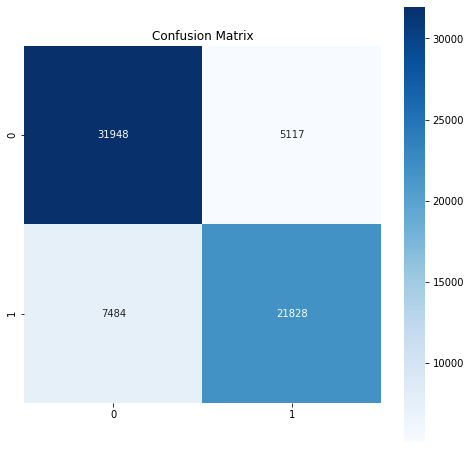

In [ ]:
x_train_bin, y_train_bin = train_bin[x_column_bin].values, train_bin[y_column_bin].values
x_test_bin, y_test_bin = test_bin[x_column_bin].values, test_bin[y_column_bin].values

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=seed, n_jobs=-1)
clf.fit(x_train_bin, np.squeeze(y_train_bin))

y_predict_bin = clf.predict(x_test_bin)

plot_confuncion_matrix(y_test_bin, y_predict_bin)
print(classification_report(y_test_bin, y_predict_bin))

In [ ]:
y_prob_bin = clf.predict_proba(x_test_bin)

total_prob_bin = y_prob_bin
# total_prob_bin = np.concatenate((total_prob_bin, y_prob_bin), axis=0)

print(y_prob_bin.shape)
print(total_prob_bin.shape)

(66377, 2)
(66377, 2)


In [ ]:
# df2 = pd.DataFrame(data=total_prob_bin, columns=['ontime', 'later'])

# df2.head(50)
# total_prob_bin[:50]

# data, _ = split_data_month_window(df, col='DocumentDate', date='2020-09-01', month_window=8)

# data.drop(labels=['DueDateToClearingDate'], axis=1, inplace=True)

# df3 = pd.concat([data, df2], axis=1)
df3.head(50)

# print('0 PPC Domestic\n1 GNP Domestic\n2 Case Ready Beef\n3 Canada Domestic\n4 PPC International\n5 JBS Beef Domestic\n6 JBS Pork Domestic\n7 Trade\n8 Plumrose\n9 Canada International\n10 JBS Beef International\n11 JBS Pork International\n12 ToRico"s\n13 JBS Plumrose-Bacon\n14 Carriers\n15 JBS Live Pork\n16 Sampco\n17 Weddel\n18 GNP International')
# plot_data_distribution(df['CorporateDivision'])

# df.head()
# df.to_csv('temp.csv')

,CompanyKey,CorporateDivision,CustomerKey,CustomerRegion,DocumentDate,DueDate,ClearingDate,PaymentTerms,DocumentNumber,DocumentAmount,InvoicedDocuments,InvoicedAmount,PaidDocuments,PaidAmount,PaidPastDocuments,PaidPastAmount,OpenDocuments,OpenAmount,PastDueDocuments,PastDueAmount,AvgDSOPastDueDocuments,AvgPastDueDays,RatioInvoicedAmountInvoicedDocuments,RatioPaidAmountPaidDocuments,RatioPaidPastAmountPaidPastDocuments,RatioOpenAmountOpenDocuments,RatioPastDueAmountPastDueDocuments,DocumentDateDayOfYear,DocumentDateWeekDay,DocumentDateDay,DocumentDateMonthEnd,DueDateDayOfYear,DueDateWeekDay,DueDateDay,DueDateMonthEnd,DueDateToMonthEnd,DocumentDateToDueDate,DocumentDateToMonthEnd,DueDateToClearingDateBIN,DueDateToClearingDateBINCT,DueDateToClearingDateBKT,DueDateToClearingDateBKTCT,ontime,later
0,49,12,3639,158,2020-01-01,2020-01-12,2020-01-14,102,931186064,57030.80,36532,1.902129e+09,35942,1.871463e+09,15592,5.077158e+08,591,30665994.12,15859,5.165251e+08,13.573435,1.015192,52067.463730,52068.960850,32562.585859,51888.314924,32569.839219,1,2,1,2020-01-31,12,6,12,2020-01-31,19,11,30,1+,1,2-3,2,0.026090,0.973910
1,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931187284,7508.29,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
2,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931186083,16745.04,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
3,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931186943,6374.88,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
4,23,4,1228,60,2020-01-01,2020-01-12,2020-01-13,102,931190591,4082.66,10851,2.473497e+08,10566,2.400210e+08,3826,7.335394e+07,285,7328703.71,3958,7.654598e+07,17.614480,1.650078,22795.108562,22716.356171,19172.488983,25714.749860,19339.560285,1,2,1,2020-01-31,12,6,12,2020-01-31,19,11,30,1+,1,1-1,1,0.073333,0.926667
5,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931186113,9698.14,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
6,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931186169,2627.41,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
7,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931186935,6779.19,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
8,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931186180,14076.75,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685,27337.511589,35937.795307,1,2,1,2020-01-31,13,0,13,2020-01-31,18,12,30,on-time,0,on-time,0,0.267134,0.732866
9,2,12,3662,170,2020-01-01,2020-01-13,2020-01-13,103,931187290,5387.20,161319,4.857412e+09,159081,4.795984e+09,88971,3.212280e+09,2247,61427388.54,90752,3.261427e+09,13.407717,1.101309,30110.599126,30148.065148,36104.795685

In [ ]:
df3.to_csv('probabilities-2020.csv', sep=';', index=False)

In [ ]:
# false_negative = test_bin[(test_bin['DueDateToClearingDateBINCT'] == 1) & (y_predict_bin == 0)]
# true_positive = test_bin[(test_bin['DueDateToClearingDateBINCT'] == 1) & (y_predict_bin == 1)]

# print(f"false_negative:\n>>> SUM {false_negative['DocumentAmount'].sum():.0f}, MIN {false_negative['DocumentAmount'].min():.0f}, MAX {false_negative['DocumentAmount'].max():.0f}\n")
# print(f"true_positive:\n>>> SUM {true_positive['DocumentAmount'].sum():.0f}, MIN {true_positive['DocumentAmount'].min():.0f}, MAX {true_positive['DocumentAmount'].max():.0f}")

# plot_data_distribution(false_negative['DocumentAmountRange'], true_positive['DocumentAmountRange'])

In [ ]:
# f_selected_bin, index_max_bin = features_selection(train_bin_res, test_bin, x_column_bin, y_column_bin, threshold=12, random_state=seed)

# print(f'\n>>> Max f1-score: {f_selected_bin[index_max_bin,0]}, {f_selected_bin[index_max_bin,1]}')
# print(f'\n>>> Attempts:\n{f_selected_bin}')

In [ ]:
y_column_bkt = np.array(['DueDateToClearingDateBKTCT'])
x_column_bkt = np.array([
                         'DocumentAmount', 'DueDateWeekDay', 'AvgPastDueDays', 'CompanyKey', 'DocumentDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'AvgDSOPastDueDocuments', 'DocumentDateToDueDate', 'PastDueAmount', 'RatioInvoicedAmountInvoicedDocuments', 'InvoicedDocuments', 'PastDueDocuments', 'InvoicedAmount', 'OpenDocuments', 'PaidAmount', 'OpenAmount', 'PaidDocuments', 'RatioPaidAmountPaidDocuments', 'RatioPastDueAmountPastDueDocuments', 'RatioOpenAmountOpenDocuments', 'RatioPaidPastAmountPaidPastDocuments', 'DueDateDayOfYear', 'DueDateDay', 'DocumentDateDayOfYear', 'DocumentDateToMonthEnd', 'DocumentDateDay', 'CustomerKey', 'CustomerRegion',
                        #  'DocumentAmount', 'DueDateWeekDay', 'CompanyKey', 'DocumentDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'RatioInvoicedAmountInvoicedDocuments', 'InvoicedDocuments', 'OpenDocuments', 'RatioPastDueAmountPastDueDocuments', 'RatioOpenAmountOpenDocuments', 'DueDateDayOfYear', 'CustomerKey', 'CustomerRegion',
                        # 'DocumentAmount', 'DueDateWeekDay', 'CompanyKey', 'DocumentDateWeekDay', 'PaymentTerms', 'CorporateDivision', 'RatioInvoicedAmountInvoicedDocuments', 'InvoicedDocuments', 'OpenDocuments', 'PaidAmount', 'RatioPaidAmountPaidDocuments', 'RatioPastDueAmountPastDueDocuments', 'RatioOpenAmountOpenDocuments', 'DueDateDayOfYear', 'CustomerKey', 'CustomerRegion',

                        # 'CompanyKey',
                        # 'CustomerKey',
                        # 'CorporateDivision',
                        # 'CustomerRegion',
                        # 'PaymentTerms',
                        # 'DocumentDateDay',
                        # 'DocumentDateWeekDay',
                        # 'DocumentDateDayOfYear',
                        # 'DocumentDateToMonthEnd',
                        # 'DueDateDay',
                        # 'DueDateWeekDay',
                        # 'DueDateDayOfYear',
                        # 'DueDateToMonthEnd',
                        # 'DocumentDateToDueDate',
                        # 'DocumentAmount',
                        # 'AvgDSOPastDueDocuments',
                        # 'AvgPastDueDays',
                        # 'PaidDocuments',
                        # 'PaidAmount',
                        # 'InvoicedDocuments',
                        # 'InvoicedAmount',
                        # 'OpenDocuments',
                        # 'OpenAmount',
                        # 'PaidPastDocuments',
                        # 'PaidPastAmount',
                        # 'PastDueDocuments',
                        # 'PastDueAmount',
                        # 'RatioInvoicedAmountInvoicedDocuments',
                        # 'RatioPaidAmountPaidDocuments',
                        # 'RatioPaidPastAmountPaidPastDocuments',
                        # 'RatioPastDueAmountPastDueDocuments',
                        # 'RatioOpenAmountOpenDocuments',
                        ])


train_bkt, test_bkt = train_bin[train_bin['DueDateToClearingDateBKTCT'] >= 0], test_bin[y_predict_bin == 1]

plot_data_distribution(train_bkt['DueDateToClearingDateBKT'], test_bkt['DueDateToClearingDateBKT'])

In [ ]:
x_train_bkt, y_train_bkt = train_bkt[x_column_bkt].values, train_bkt[y_column_bkt].values
x_test_bkt, y_test_bkt = test_bkt[x_column_bkt].values, test_bkt[y_column_bkt].values

clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=seed, n_jobs=-1)
clf.fit(x_train_bkt, np.squeeze(y_train_bkt))

y_predict_bkt = clf.predict(x_test_bkt)

plot_confuncion_matrix(y_test_bkt, y_predict_bkt)
print(classification_report(y_test_bkt, y_predict_bkt))

In [ ]:
# f_selected_bkt, index_max_bkt = features_selection(train_bkt, test_bkt, x_column_bkt, y_column_bkt, threshold=12, random_state=seed)

# print(f'\n>>> Max f1-score: {f_selected_bkt[index_max_bkt,0]}, {f_selected_bkt[index_max_bkt,1]}')
# print(f'\n>>> Attempts:\n{f_selected_bkt}')

In [ ]:
# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# # !nvidia-smi
# # !pip install -q tensorflow-gpu

# def binary_encoding(df, cols):
#     for col in cols:
#         bincol = np.array([str('{0:b}'.format(x)) for x in df[col[1]].values])
#         header = np.array([f'{col[1]}{i}' for i in range(col[0])])
#         newcol = np.zeros((bincol.shape[0], col[0]), dtype=np.int8)

#         for i in range(bincol.shape[0]):
#             a = np.array(list(bincol[i]), dtype=np.int8)
#             newcol[i][col[0] - len(a):] = a

#         df2 = pd.DataFrame(newcol, columns=header)
#         df.reset_index(drop=True, inplace=True)
#         df = pd.concat([df, df2], axis=1)
#         df.drop(columns=[col[1]], inplace=True)
#     return df


# train_nn = train_res[x_column].copy()
# test_nn = test[x_column].copy()

# cols = [(32, 'CompanyKey'),
#         (12, 'CorporateDivision'),
#         (32, 'CustomerKey'),
#         (12, 'CustomerRegion'),
#         (12, 'PaymentTerms'),
#         (9, 'DocumentDateDayOfYear'),
#         (3, 'DocumentDateWeekDay'),
#         (5, 'DocumentDateDay'),
#         (9, 'DueDateDayOfYear'),
#         (3, 'DueDateWeekDay'),
#         (5, 'DueDateDay'),
#         (5, 'DueDateToMonthEnd'),
#         (9, 'DocumentDateToDueDate'),
#         (5, 'DocumentDateToMonthEnd'),]

# train_nn = binary_encoding(train_nn, cols)
# test_nn = binary_encoding(test_nn, cols)


# x_train, x_valid, y_train, y_valid = train_test_split(train_nn.values, train_res[y_column].values,
#                                                       test_size=0.1, shuffle=True, random_state=seed,
#                                                       stratify=train_res[y_column].values)

# y_train_categorical = tf.keras.utils.to_categorical(y_train)
# y_valid_categorical = tf.keras.utils.to_categorical(y_valid)



# def create_model():
#     model = tf.keras.models.Sequential(name='cubricks')

#     model.add(tf.keras.layers.Input(shape=train_nn.values.shape[1]))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))

#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))
#     model.add(tf.keras.layers.Dropout(rate=0.1))

#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))
#     model.add(tf.keras.layers.Dropout(rate=0.1))

#     model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
#     model.add(tf.keras.layers.BatchNormalization(renorm=True))
#     model.add(tf.keras.layers.Dropout(rate=0.1))

#     model.add(tf.keras.layers.Dense(2, activation='softmax'))
#     return model


# model = create_model()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8, amsgrad=True),
#               loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1, reduction=tf.keras.losses.Reduction.SUM),
#               metrics=['accuracy'])

# model.summary()
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-8, patience=20, restore_best_weights=True, verbose=1)]

# model.fit(x_train,
#           y_train_categorical,
#           validation_data=(x_valid, y_valid_categorical),
#           callbacks=callbacks,
#           batch_size=256,
#           epochs=10000,
#           verbose=1)

In [ ]:
# predict = np.argmax(model.predict(test_nn.values), axis=1)
# plot_confuncion_matrix(y_test, predict)

# # plot_feature_importance(x_column, clf.feature_importances_)
# print(classification_report(y_test, predict))